In [ ]:
#| hide
from chewc.core import *
from chewc.pop import *
from chewc.sp import *

# chewc

> JAX breeding sim

This file will become your README and also the index of your documentation.

## Developer Guide

If you are new to using `nbdev` here are some useful pointers to get you started.

### Install chewc in Development mode

```sh
# make sure chewc package is installed in development mode
$ pip install -e .

# make changes under nbs/ directory
# ...

# compile to have changes apply to chewc
$ nbdev_prepare
```

## Usage

### Installation

Install latest from the GitHub [repository][repo]:

```sh
$ pip install git+https://github.com/cjGO/chewc.git
```


[repo]: https://github.com/cjGO/chewc
[docs]: https://cjGO.github.io/chewc/
[pypi]: https://pypi.org/project/chewc/
[conda]: https://anaconda.org/cjGO/chewc

### Documentation

Documentation can be found hosted on this GitHub [repository][repo]'s [pages][docs].

[repo]: https://github.com/cjGO/chewc
[docs]: https://cjGO.github.io/chewc/

## How to use

Fill me in please! Don't forget code examples:

In [ ]:
import jax
import jax.numpy as jnp

# Assuming your classes are in these files as discussed
from chewc.sp import SimParam
from chewc.pop import quick_haplo, Population
from chewc.trait import add_trait_a # Import the new function

# --- 1. JAX Setup ---
key = jax.random.PRNGKey(42)

# --- 2. Define the Genome's "Blueprint" ---
n_chr = 3
n_loci_per_chr = 100
ploidy = 2 
gen_map = jnp.array([jnp.linspace(0, 1, n_loci_per_chr) for _ in range(n_chr)])
centromeres = jnp.full(n_chr, 0.5)

# --- 3. Instantiate Initial Simulation Parameters ---
# Create the initial SimParam object. It does NOT contain a founder population yet.
SP = SimParam(
    gen_map=gen_map,
    centromere=centromeres,
    ploidy=ploidy
)

print("\n--- Initial Simulation Parameters Created ---")
print(SP)
print("-" * 35)

# --- 4. Create the Founder Population ---
# Create the founder population using the initial SimParam object.
key, pop_key = jax.random.split(key)
n_founders = 50 

founder_pop = quick_haplo(
    key=pop_key,
    sim_param=SP, # Use the initial SP
    n_ind=n_founders,
    inbred=False
)

print("\n--- Founder Population Created ---")
print(founder_pop)
print(f"Genotype array shape: {founder_pop.geno.shape}")
print("-" * 35)


# --- 5. Finalize Simulation Parameters ---
# Now, create the *final* version of the SimParam object by adding the founder population.
# The .replace() method returns a new, updated, immutable object.
SP = SP.replace(founderPop=founder_pop)

print("\n--- Simulation Parameters Finalized with Founder Pop ---")
print(SP)
# Note: The __repr__ for SimParam doesn't show the founderPop, but it is there.
print(f"Number of traits before: {SP.n_traits}")
print("-" * 35)


# --- 6. Add Two Correlated Additive Traits ---
key, trait_key = jax.random.split(key)

# Define the parameters for the two new traits
n_qtl_per_chr = 10
trait_means = jnp.array([10.0, 20.0])
trait_vars = jnp.array([1.5, 2.5])
trait_cor = jnp.array([[1.0, 0.8],
                       [0.8, 1.0]])

# Call the add_trait_a function. It now works because SP.founderPop exists.
SP_with_traits = add_trait_a(
    key=trait_key,
    sim_param=SP,
    n_qtl_per_chr=n_qtl_per_chr,
    mean=trait_means,
    var=trait_vars,
    cor_a=trait_cor
)

print("\n--- Correlated Additive Traits Added ---")
print(f"SimParam object updated: {SP_with_traits}")
print(f"Number of traits after: {SP_with_traits.n_traits}")
print("\nDetails of the new traits:")
for trait in SP_with_traits.traits:
    print(f"  - {trait.name}: intercept={trait.intercept:.4f}, n_qtl={trait.n_loci}")
print("-" * 35)


--- Initial Simulation Parameters Created ---
SimParam(nChr=3, nTraits=0, ploidy=2, sexes='no')
-----------------------------------

--- Founder Population Created ---
Population(nInd=50, nTraits=0, has_ebv=No)
Genotype array shape: (50, 3, 2, 100)
-----------------------------------

--- Simulation Parameters Finalized with Founder Pop ---
SimParam(nChr=3, nTraits=0, ploidy=2, sexes='no')
Number of traits before: 0
-----------------------------------

--- Correlated Additive Traits Added ---
SimParam object updated: SimParam(nChr=3, nTraits=2, ploidy=2, sexes='no')
Number of traits after: 2

Details of the new traits:
  - Trait1: intercept=10.7238, n_qtl=30
  - Trait2: intercept=19.9118, n_qtl=30
-----------------------------------


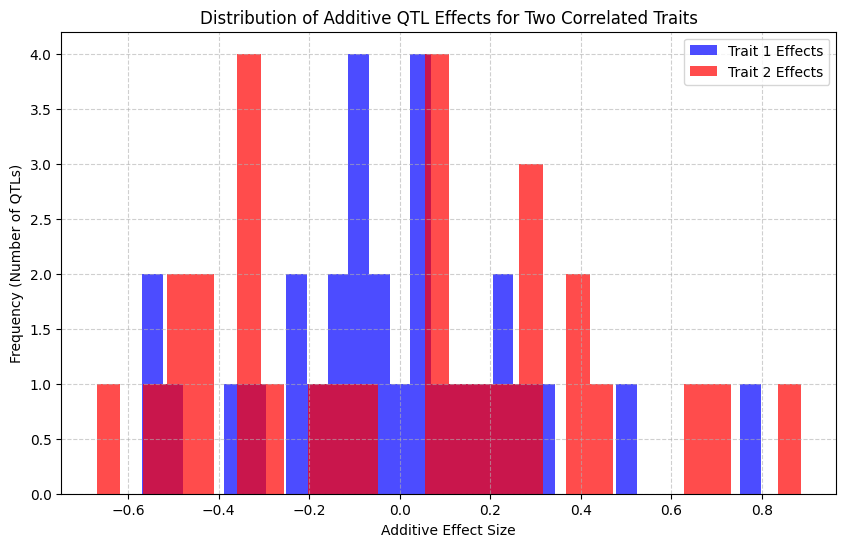

In [ ]:
import matplotlib.pyplot as plt

# --- 6. Visualize the Trait Effects ---

# Extract the additive effects for each trait from the final SimParam object
trait1_effects = SP_with_traits.traits[0].add_eff
trait2_effects = SP_with_traits.traits[1].add_eff

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the histogram for Trait 1
plt.hist(trait1_effects, bins=30, alpha=0.7, label='Trait 1 Effects', color='blue')

# Plot the histogram for Trait 2 on the same axes
plt.hist(trait2_effects, bins=30, alpha=0.7, label='Trait 2 Effects', color='red')

# Add titles and labels for clarity
plt.title('Distribution of Additive QTL Effects for Two Correlated Traits')
plt.xlabel('Additive Effect Size')
plt.ylabel('Frequency (Number of QTLs)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

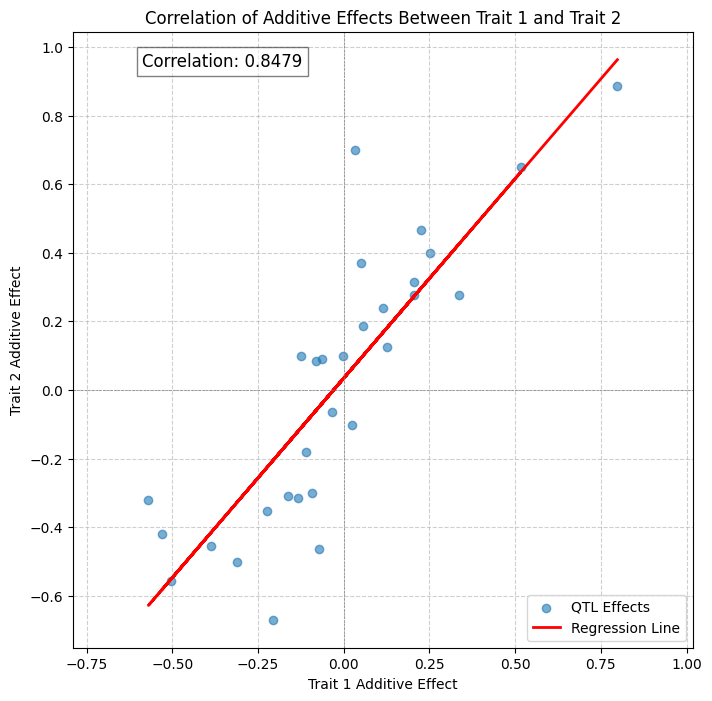

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# --- 7. Create a Scatterplot to Visualize Correlation ---

# Extract the additive effects for each trait, assuming they are the first two traits
trait1_effects = SP_with_traits.traits[0].add_eff
trait2_effects = SP_with_traits.traits[1].add_eff

# --- Create the Plot ---
plt.figure(figsize=(8, 8))

# Create the scatterplot
plt.scatter(trait1_effects, trait2_effects, alpha=0.6, label='QTL Effects')

# --- Add a Regression Line ---
# This line helps visualize the strength and direction of the correlation
m, b = jnp.polyfit(trait1_effects, trait2_effects, 1)
plt.plot(trait1_effects, m * trait1_effects + b, color='red', linewidth=2, label='Regression Line')

# --- Calculate and Display the Correlation Coefficient ---
# This provides a quantitative measure of the correlation.
correlation = jnp.corrcoef(trait1_effects, trait2_effects)[0, 1]
plt.text(plt.xlim()[0] + 0.05, plt.ylim()[1] - 0.1, f'Correlation: {correlation:.4f}',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))


# --- Add Titles and Labels ---
plt.title('Correlation of Additive Effects Between Trait 1 and Trait 2')
plt.xlabel('Trait 1 Additive Effect')
plt.ylabel('Trait 2 Additive Effect')
plt.axhline(0, color='grey', lw=0.5, linestyle='--')
plt.axvline(0, color='grey', lw=0.5, linestyle='--')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensure the plot axes are scaled equally

# Show the plot
plt.show()